# Working with Time Series

Pandas was developed in the context of financial modeling. As such, it contains a fairly extensive set of tools for working with dates, times, and time-indexed data. Date and time data comes in a few flavors:

- `time stamps` reference particular moments in time.
- `time intervals` and `periods` reference a length of time between a particular beginning and end point.
    - `periods` usually reference a special case of time intervals in which each interval is of uniform length that is ordered, sequential, and without overlap.
- `time deltas` or `durations` reference an exact length of time, disconnected or unconcerned with information referencing specific dates and time.

In this section, we will introduce how to work with each of these types of data/time data in Pandas.

## Dates and Times in Python

While the time series tools provided by Pandas tend to be the most useful for data science applications, it is helpful to see their relationship to other packages used in Python.

### Native Python dates and times: `datetime` and `dateutil`

Python's basic objects for working with dates and timess reside in the `datetime` module. Along with the third-party `dateutil` module, you can use it to quickly perform a host of useful functionalities on dates and times.

In [2]:
from datetime import datetime
datetime(year=2015, month=7, day=4)

datetime.datetime(2015, 7, 4, 0, 0)

In [3]:
from dateutil import parser
date = parser.parse('4th of July, 2015')
date

datetime.datetime(2015, 7, 4, 0, 0)

And with `datetime` objects, it is possible to perform convertions like below:

In [4]:
date.strftime('%A')

'Saturday'

`strftime` takes _standard string format codes_ arguments and interprets them accordingly. `%A` in the above case is asking for **the day of the week**.

A related package to be aware of is `pytz`, which contains tools for working with the most migrane-inducing piece of time series data: _time zones_.


The power of `datetime` and `dateutil` lie in their flexibility and easy syntax: you can use these objects and their built-in methods to easily perform nearly operation you might be interested in. Where they break down is when you wish to work with large arrays of dates and times.

Just as lists of Python numerical variables are suboptimal compared to _NumPy_ typed numerical arrays, lists of Python datetime objects are suboptimal compared to typed arrays of encoded dates.

## Typed arrays of times: *NumPy*

The weakness of Python's datetime format inspired the *NumPy* team to add a set of native time series data type to *NumPy*. The `datetime64` dtype encodes dates as 64-bit integers, thus allowing arrays of dates to be represented very compactly.

In [5]:
import numpy as np
date = np.array('2105-07-04', dtype=np.datetime64)
date

array('2105-07-04', dtype='datetime64[D]')

Once we have formatted the date, we can quickly perform vectorized operations on it.

In [6]:
date + np.arange(12)

array(['2105-07-04', '2105-07-05', '2105-07-06', '2105-07-07',
       '2105-07-08', '2105-07-09', '2105-07-10', '2105-07-11',
       '2105-07-12', '2105-07-13', '2105-07-14', '2105-07-15'],
      dtype='datetime64[D]')

Because of the uniform type in *NumPy* `datetime64` arrays, this type of operation can be accomplished more quickly than if we were directly with Python's native `datetime` objects, especially as the arrays increase in size.

One detail of the `datetime64` and `timedelta64` objects is that they are built on a _fundamental time unit_. Because the `datetime64` object is limited to 64-bit precision, the range of encodable times is $2^{64} \ \times\ $ this fundamental unit. In other words, `datetime64` imposes a trade-off between _time resolution_ and _maximum time span_.

> If you want a _time resolution_ of 1 nanosecond, you only have enough information to encode a range of $2^{64}$ nanoseconds, or just under 600 years. _NumPy_ will infer the desired unit from the input.

In [7]:
np.datetime64('2015-07-04')

numpy.datetime64('2015-07-04')

In [8]:
np.datetime64('2015-07-04 12:00')

numpy.datetime64('2015-07-04T12:00')

Notice that the time zone is automatically set to thee local time on the computer executing the code. You can force any desired fundamental unit using one of many format codes. The example below forces a nanosecond-based time.

In [9]:
np.datetime64('2015-07-04 12:59:59.50', 'ns')

numpy.datetime64('2015-07-04T12:59:59.500000000')

For the types of data we see in the real world, a useful default is `datetime[ns]`, as it can encode a useful range of modern dates with a suitably fine precision.

Finally, we will note that while the `datetime64` data type addresses some of the deficiencies of the built-in Python `datetime` type, it lacks many of the convenient methods and functions provided by `datetime` and especially `dateutil`.

## Dates and Times in Pandas: The Best of Python/NumPy Worlds

Pandas builds all the tools just discussed to provide a `Timestamp` object, which combines the ease-of-use of `datetime` and `dateutil` with the efficient storage and vectorized interface of `numpy.datetime64`. From a group of these `Timestamp` objects, Pandas can construct a `DattimeIndex` that can be used to index data in a `Series` or `DataFrame`.

In [10]:
import pandas as pd
date = pd.to_datetime("4th of July, 2015")
date

Timestamp('2015-07-04 00:00:00')

In [11]:
date.strftime('%A')

'Saturday'

Additionally, we can do NumPy-stype vectorized operations directly.

In [12]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
              dtype='datetime64[ns]', freq=None)

### Pandas Time Series: Indexing by Time

Where the Pandas Time series tools really become useful is when you begin to _index data by timestamps_. For example, we can construct a `Series` object that has time indexed data.

In [13]:
index = pd.DatetimeIndex(['2014-07-04', '2014-08-04',
                          '2015-07-04', '2015-08-04'])

Now that we have this data in a `Series`, we can make use of any of the `Series` indexing patterns we discussed in previous sections, passing values that can be coerced into dates.

In [14]:
data = pd.Series([0, 1, 2, 3], index=index)

In [15]:
data['2014-07-04' : '2015-07-04']

2014-07-04    0
2014-08-04    1
2015-07-04    2
dtype: int64

There are additional special date-only indexing operations, such as passing a year to obtain a slice of all data from that year.

In [16]:
data['2015']

2015-07-04    2
2015-08-04    3
dtype: int64

### Pandas Time Series Data Structures

This section will introduce the fundamental Pandas data structures for working with time series data.

- For _time stamps_, Pandas provides the `Timestamp` type. As mentioned before, it is essentially a replacement for Python's native `datetime`, but is based on the more efficient `numpy.datetime64` data type. The associated Index structure is `DatetimeIndex`.
- For _time Periods_, Pandas provides the `Period` type. This encodes a fixed frequency interval based on `numpy.datetime64`. The associated index structure is `PeriodIndex`.
- For _time deltas_ or _durations_, Pandas provides the `Timedelta` type. `Timedelta` is a more efficient replacement for Python's native `datetime.timedelta` type, and is based on `numpy.timedelta64`. The associated index structure is `TimedeltaIndex`.

The most fundamental of these date/time objects are the `Timestamp` and `DatetimeIndex` objects. While these class objects can be invoked directly, it is more common to use the `pd.to_datetime()` function, which can parse a wide variety of formats. Passing a single date to `pd.to_datetime()` yields a `Timestamp`; passing a series of dates by default yields a `DatetimeIndex`.

In [17]:
dates = pd.to_datetime([datetime(2015, 7, 3), '4th of July, 2015',
                        '2015-Jul-6', '07-07-2015', '20150708'])

dates

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
               '2015-07-08'],
              dtype='datetime64[ns]', freq=None)

Any `DatetimeIndex` can be converted to a `PeriodIndex` with the `to_period()` function with the addition of a frequency code; here we'll use `D` to indicate daily frequency.

In [18]:
dates.to_period('D')

PeriodIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
             '2015-07-08'],
            dtype='period[D]')

A `TimedeltaIndex` is created, for example, when a date is subtracted from another.

In [19]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

### Regular Sequences: `pd.date_range()`

To make the creation of regular date sequences more convenient, Pandas offers a few functions for this purpose: `pd.date_range()` for timestamps, `pd.period_range()` for periods, and `pd.timedelta_range()` for time deltas. We've seen that Python's `range()` and NumPy's `np.range()` turn a startpoint, endpoint, and optional stepsize into a sequence. Similarly, `pd.date_range()` accepts a start date, an end state, and an optional frequency code to create a regular sequence of dates.

By default, the frequency is one day.

In [20]:
pd.date_range('2015-07-03', '2015-07-10')

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

Alternatively, the date range can be specified not with a start and endpoint, but with a startpoint and a number of periods.

In [21]:
pd.date_range('2015-07-03', periods=8)

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

The spacing can be modified by altering the `freq` argument, which defaults to `D`. For example, here we will construct a range of hourly timestamps.

In [22]:
pd.date_range('2015-07-03', periods=8, freq='H')

DatetimeIndex(['2015-07-03 00:00:00', '2015-07-03 01:00:00',
               '2015-07-03 02:00:00', '2015-07-03 03:00:00',
               '2015-07-03 04:00:00', '2015-07-03 05:00:00',
               '2015-07-03 06:00:00', '2015-07-03 07:00:00'],
              dtype='datetime64[ns]', freq='H')

To create regular sequences of `Period` or `Timedelta` values, the very similar `pd.period_range()` and `pd.timedelta_range()` functions are useful. Here are some monthly periods.

In [23]:
pd.period_range('2015-07', periods=8, freq='M')

PeriodIndex(['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02'],
            dtype='period[M]')

And a sequence of durations increasing by an hour.

In [24]:
pd.timedelta_range(0, periods=10, freq='H')

TimedeltaIndex(['0 days 00:00:00', '0 days 01:00:00', '0 days 02:00:00',
                '0 days 03:00:00', '0 days 04:00:00', '0 days 05:00:00',
                '0 days 06:00:00', '0 days 07:00:00', '0 days 08:00:00',
                '0 days 09:00:00'],
               dtype='timedelta64[ns]', freq='H')

### Frequencies and Offsets

Fundamental to these Pandas time series tools is the concept of frequency or date offset. Just as we saw the `D` (day) and `H` (hour) codes above, we can use such codes to specify any desired frequency spacing.

The monthly, quarterly, and annual frequencies are all marked at the end of the specified period. By adding an `S` suffix to any of these, they will instead be marked at the beginning.

![frequencies and offsets](./res/img/code_description.png)

Additionally, you can change the month used to mark any quarterly or annual code by addding a three-letter month code as a suffix:
- `Q-JAN`, `BQ-FEB`, `QS-MAR`, `BQS-APR`, etc.
- `A-JAN`, `BA=FEB`, `AS-MAR`, `BAS-APR`, etc.

In the same way, the split-point of the weekly frequency can be modified by adding a three-letter weekday code:
- `W-SUN`, `W-MON`, `W-TUE`, `W-WED`, etc.

In addition, codes can be combined with numbers to specify other frequencies. E.g., for a frequency of 2 hours and 30 minutes, we can combine the hour `H` and minute `T` codes as follows:

In [25]:
pd.timedelta_range(0, periods=9, freq='2H30T')

TimedeltaIndex(['0 days 00:00:00', '0 days 02:30:00', '0 days 05:00:00',
                '0 days 07:30:00', '0 days 10:00:00', '0 days 12:30:00',
                '0 days 15:00:00', '0 days 17:30:00', '0 days 20:00:00'],
               dtype='timedelta64[ns]', freq='150T')

All of these short codes refer to specific instances of Pandas time series offsets, which can be found in the `pd.tseries.offsets` module. A business day offset can be created as follows:

In [26]:
from pandas.tseries.offsets import BusinessDay
pd.date_range('2015-07-01', periods=5, freq=BusinessDay())

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-06',
               '2015-07-07'],
              dtype='datetime64[ns]', freq='B')

### Resampling, Shifting, and Windowing

The ability to use dates and times as indices to intuitively organize and access data is an important piece of the Pandas time series tools. The benefits of indexed data in general (automatic alignment during operations, intuitive data slicing and access, etc.) still apply, and Pandas provides several additional time series-specific operations.

We will take a look at a few of those here, using some stock price data as an example. Because Pandas was developed largely in a finance context, it includes some very specific tools for financial data. For example, the accompanying `pandas-datareader` package knows how to import financial data from a number of available sources, including Yahoo finance, Google, finance, and others.

In [27]:
from pandas_datareader import data

goog = data.DataReader('GOOG', start='2004', end='2016', data_source='yahoo')
goog.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,51.835709,47.800831,49.813290,49.982655,44871361.0,49.982655
2004-08-20,54.336334,50.062355,50.316402,53.952770,22942874.0,53.952770
2004-08-23,56.528118,54.321388,55.168217,54.495735,18342897.0,54.495735
2004-08-24,55.591629,51.591621,55.412300,52.239197,15319808.0,52.239197
2004-08-25,53.798351,51.746044,52.284027,52.802086,9232276.0,52.802086


In [28]:
goog = goog['Close'] # used for simplicity

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

<AxesSubplot:xlabel='Date'>

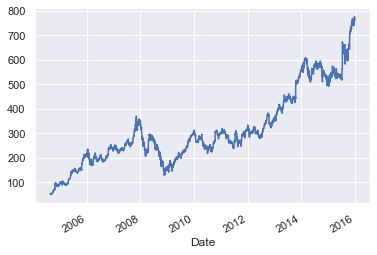

In [30]:
goog.plot()

### Resampling and Converting Frequencies

One common need for time series data is resampling at a higher or lower frequency. This can be done using the `resample()` method, or the much simpler `asfreq()` method. The primary difference between the two is that `resample()` is fundamentally a _data aggregation_, which `asfreq()` is fundamentally a _data selection_.

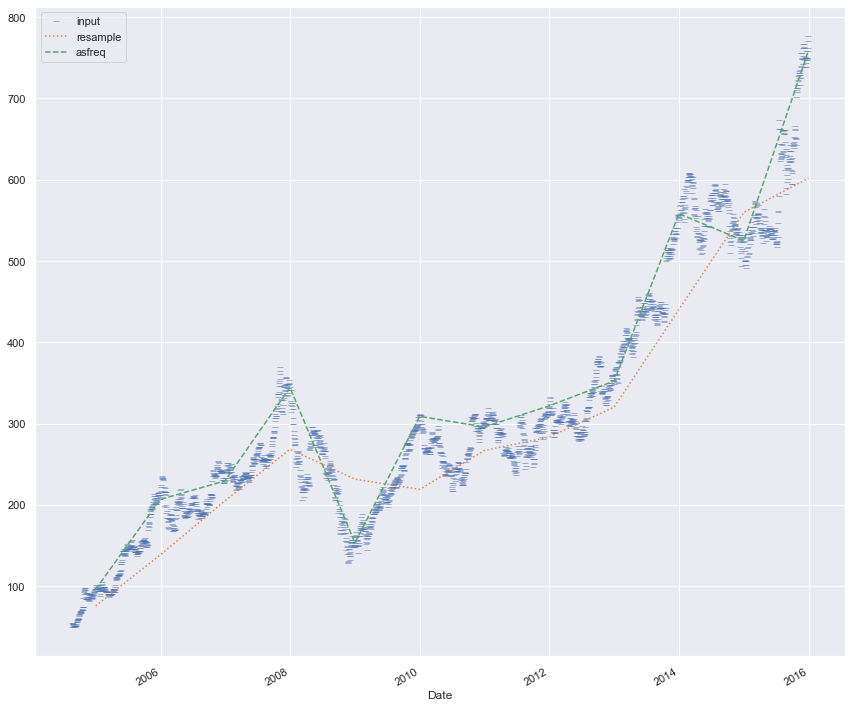

In [31]:
goog.plot(alpha=0.5, style='_', figsize=(12,10)) # unmodified original plot
goog.resample('BA').mean().plot(style=':') # resampled yearly using previous yearly average (aggregation)
goog.asfreq('BA').plot(style='--') # resampled yearly at the year-end value (selection)
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left')
plt.tight_layout()
plt.show()

For **up-sampling**, `resample()` and `asfreq()` are largely equivalent, though resample has many more options available. In this case, the default for both methods is to leave the up-sampled points empty (filled with NA values). Just as with the `pd.fillna()` function, `asfreq()` accepts a `method` argument to specify how values are imputed. Here, we will resample the business day at a daily frequency (i.e., including weekends):

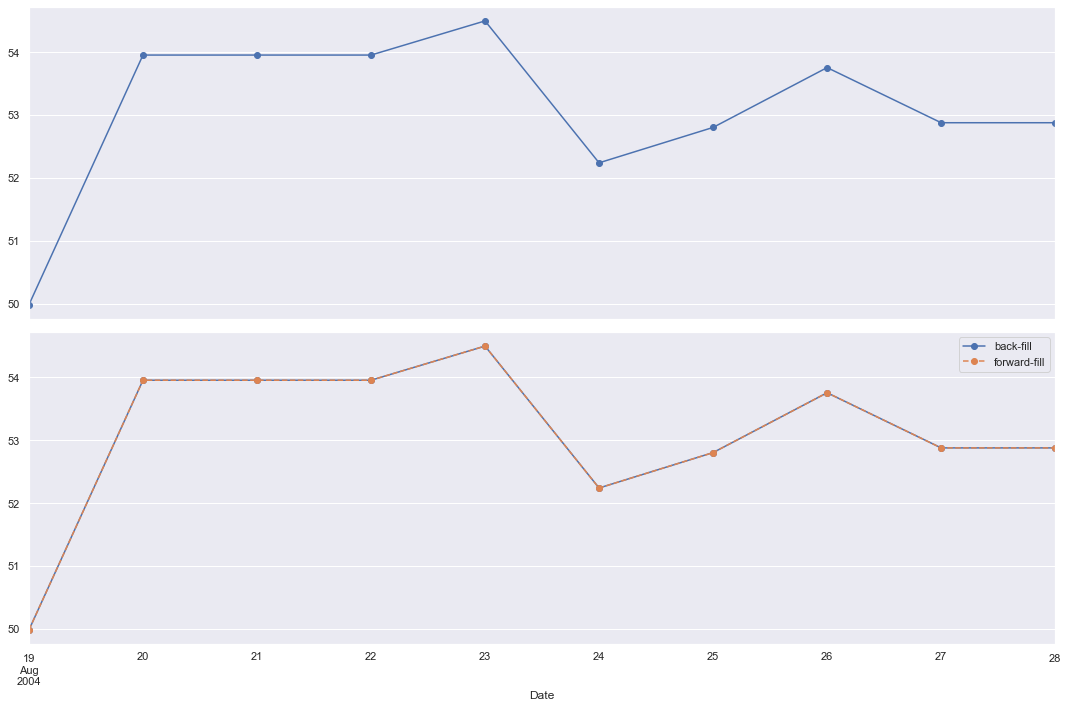

In [59]:
# select the sample the data
fig, ax = plt.subplots(2, sharex=True, figsize=(15,10))
data = goog.iloc[:10]

# original data
data.asfreq('D').plot(ax=ax[0], marker='o')

# upsampling using forefill and backfill as examples
data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"])
plt.tight_layout()
plt.show()

The top panel is the default: non-business days are left as NA values and do not appear on the plot. The bottom panel shows the differences between two strategies for filling the gaps: forward-filling and backward-filling.

### Time-Shifts

Another common time series-specific operation is shifting of data in time. Pandas has two closely related methods for computing this: `shift()` and `tshift()`. In short, the difference between them is that `shift()` _shifts the data_, while `tshift()` _shifts the index_. In both cases, the shift is specified in multiples of the frequency.

/var/folders/xm/yv4_9lnx4vxb435678j65d140000gn/T/ipykernel_6849/719412106.py:9: FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.
  goog.tshift(900).plot(ax=ax[2])


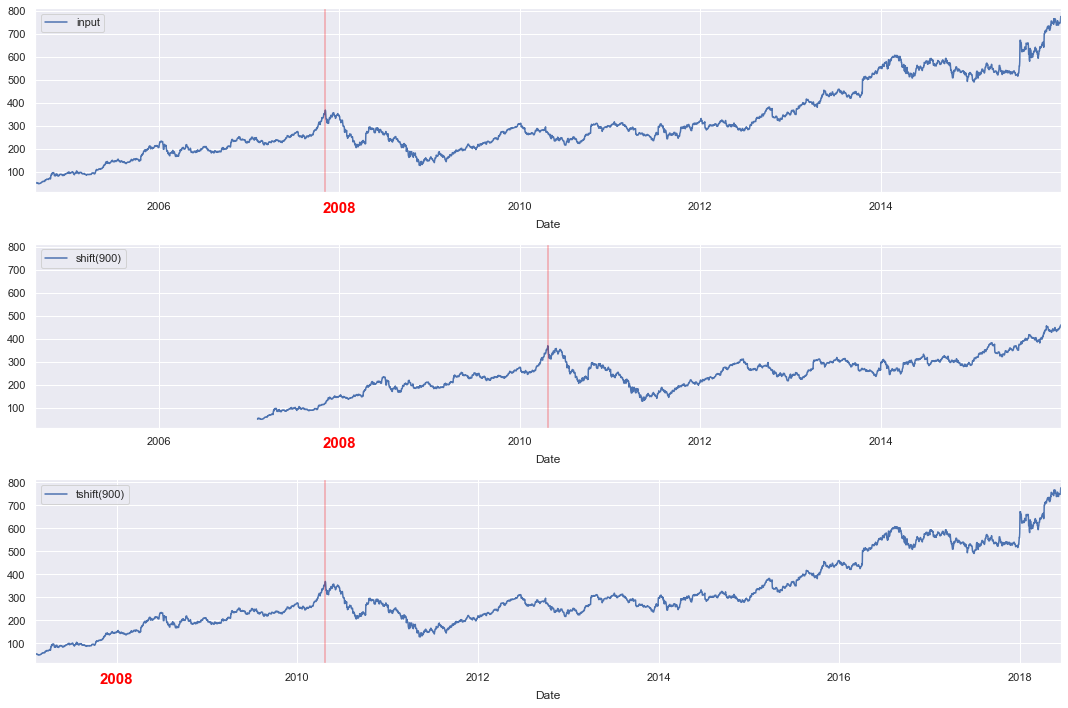

In [58]:
fig, ax = plt.subplots(3, sharey=True, figsize=(15,10))

# apply a frequency to the data
goog = goog.asfreq('D', method='pad')

# difference between data and index shifting, respectively
goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.tshift(900).plot(ax=ax[2])

# legends and annotations
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')

ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[2].set(weight='heavy', color='red', fontsize=15)
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[2].set(weight='heavy', color='red', fontsize=15)
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red', fontsize=15)
ax[2].axvline(local_max + offset, alpha=0.3, color='red')

plt.tight_layout()
plt.show()

`shift(900)` shifts the _data_ by 900 days, pushing some of it off the end of the graph (and leaving NA values at the other end). `tshift(900)` shift the _index_ values by 900 days.

A common context for this type of shift is in computing differences over time.

/var/folders/xm/yv4_9lnx4vxb435678j65d140000gn/T/ipykernel_6849/3956547425.py:1: FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.
  ROI = 100 * (goog.tshift(-365) / goog - 1)


Text(0, 0.5, '% Return on Investment')

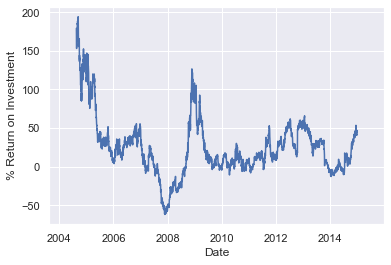

In [34]:
ROI = 100 * (goog.tshift(-365) / goog - 1)
ROI.plot()
plt.ylabel('% Return on Investment')

### Rolling Windows

**Rolling statistics** are a third type of time series-specific operation implemented by Pandas. These can be accomplished via the `rolling()` attribute of `Series` and `DataFrame` objects, which returns a view similar to what we saw with the `groupby` operation. This rolling view makes available a number of aggregation operations by default.

For example, here is the one-year centered rolling mean and standard deviation of the Google stock prices:

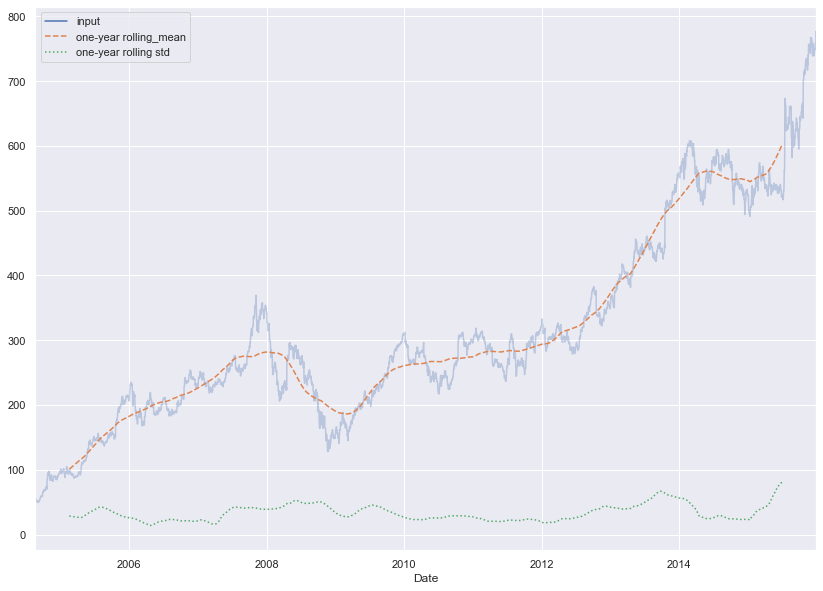

In [35]:
rolling = goog.rolling(365, center=True)

data = pd.DataFrame({'input' : goog,
                     'one-year rolling_mean' : rolling.mean(),
                     'one-year rolling std' : rolling.std()})
ax = data.plot(style=['-', '--', ':'], figsize=(14,10))
ax.lines[0].set_alpha(0.3)

As with group-by operations, the `aggregate()` and `apply()` methods can be used for custom rolling computations.

## Example: Visualizing Seattle Bicycle Counts

As a more involved example of working with some time series data, let's take a look at bicycle counts on Seattle's `Fremont Bridge`. This data comes from an automated bicycle counter, installed in late 2012, which has inductive sensors on the east and west sidewalks of the bridge.

In [36]:
data = pd.read_csv('./res/data/fremont_bridge_bicycle_counter.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


In [37]:
# shorten the column names
data.columns = ['Total', 'West', 'East']

In [38]:
data.dropna().describe()

,Total,West,East
count,150878.000000,150878.000000,150878.000000
mean,109.454539,49.594885,59.859655
std,139.444543,64.153845,86.599269
min,0.000000,0.000000,0.000000
25%,14.000000,6.000000,7.000000
50%,59.000000,27.000000,30.000000
75%,144.000000,67.000000,74.000000
max,1097.000000,698.000000,850.000000


### EDA

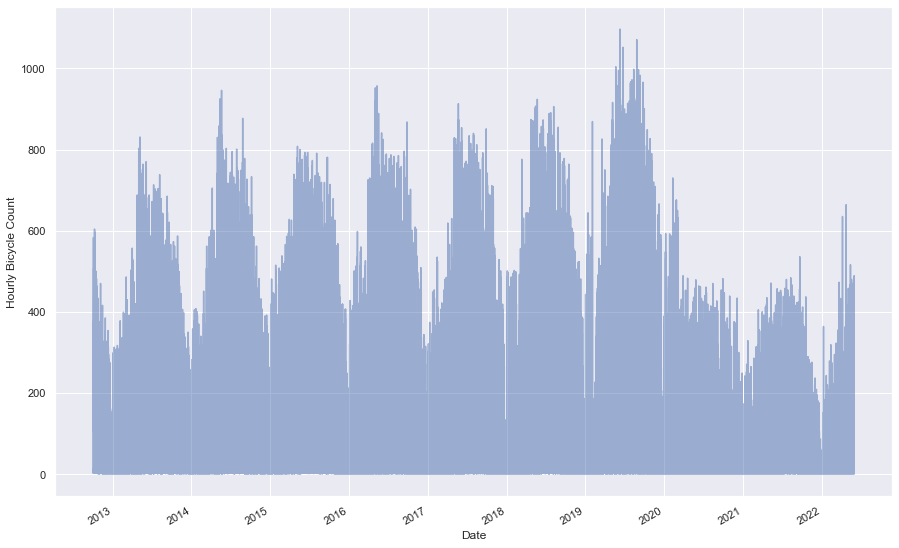

In [39]:
data['Total'].plot(figsize=(15,10), alpha=0.5)
plt.ylabel('Hourly Bicycle Count')
plt.show()

The hourly samples are far too dense. We can gain more insight by resampling the data to a coarser grid.

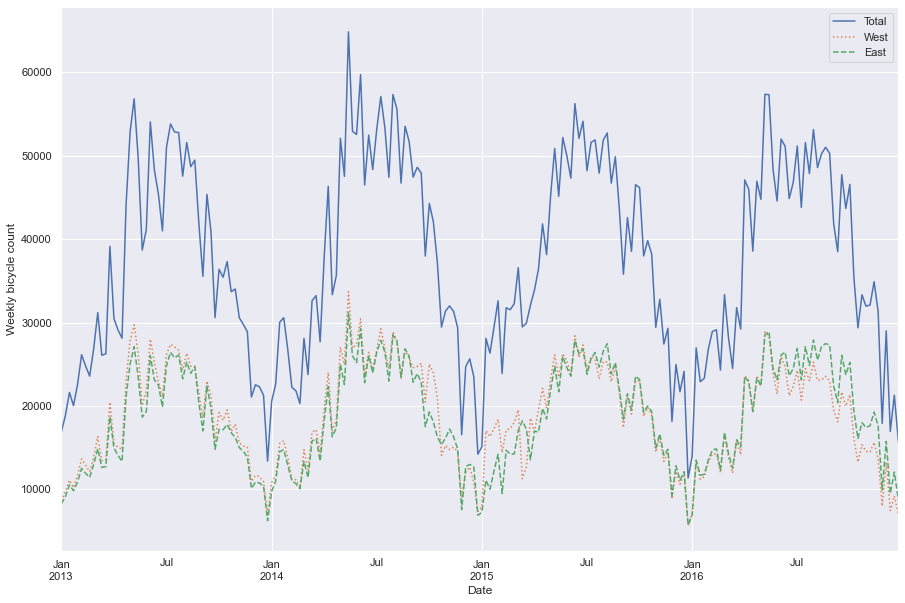

In [40]:
weekly = data.resample('W').sum()['2013' : '2016']
weekly.plot(style=['-', ':', '--'], figsize=(15,10))
plt.ylabel('Weekly bicycle count')
plt.show()

This shows us some interesting seasonal trends. As expected, people bicycle more in the summer than in the winter, and even within a particular season, bicycle use varies from week to week (likely dependent on weather).

Another way that comes in handy for aggregating the data is to use a rolling mean using the `pd.rolling_mean()` function. Here, we'll do a 30-day rolling mean of our data, making sure to center the window.

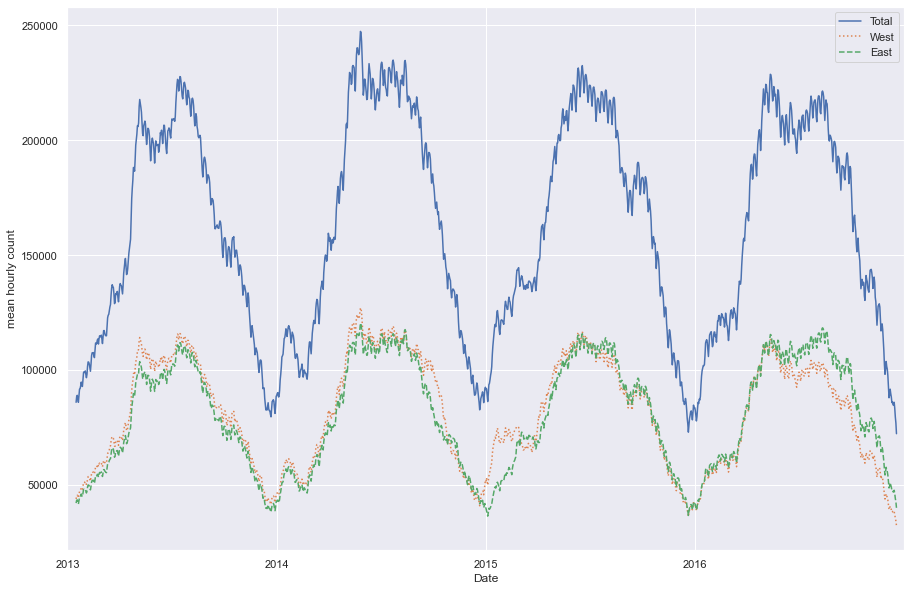

In [41]:
daily = data.resample('D').sum()['2013' : '2016']
daily.rolling(30, center=True).sum().plot(style=['-', ':', '--'], figsize=(15,10))
plt.ylabel('mean hourly count')
plt.show()

The jaggedness of the result is due to the hard cutoff of the window. We can get a smoother version of a rolling mean using a window function (e.g., a Gaussian window). The folling specifies both the width of the window (50 days in this case) and the width of the Gaussian within the window (we chose 10 days).

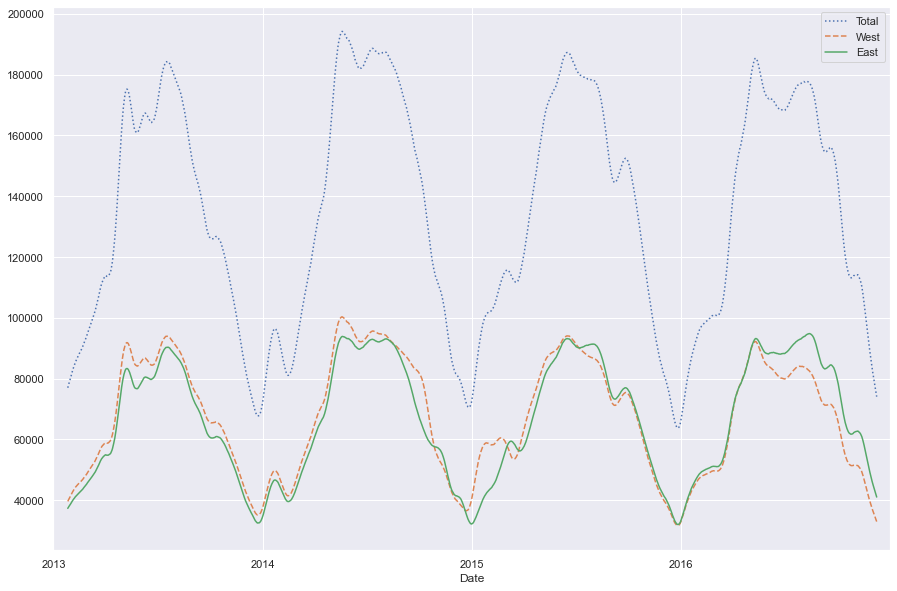

In [49]:
daily.rolling(
    50, # days
    center=True,
    win_type='gaussian').sum(std=10).plot(style=[':', '--', '-'], figsize=(15,10)) # choosing 10-day window
plt.show()


### Digging Into the Data

While the smoothed data views are useful to get an idea of the general trend in the data, they hide much of the interesting structure. E.g., we might want to look at the average traffic as a function of the time of day. We can do this using the `GroupBy` functionality.

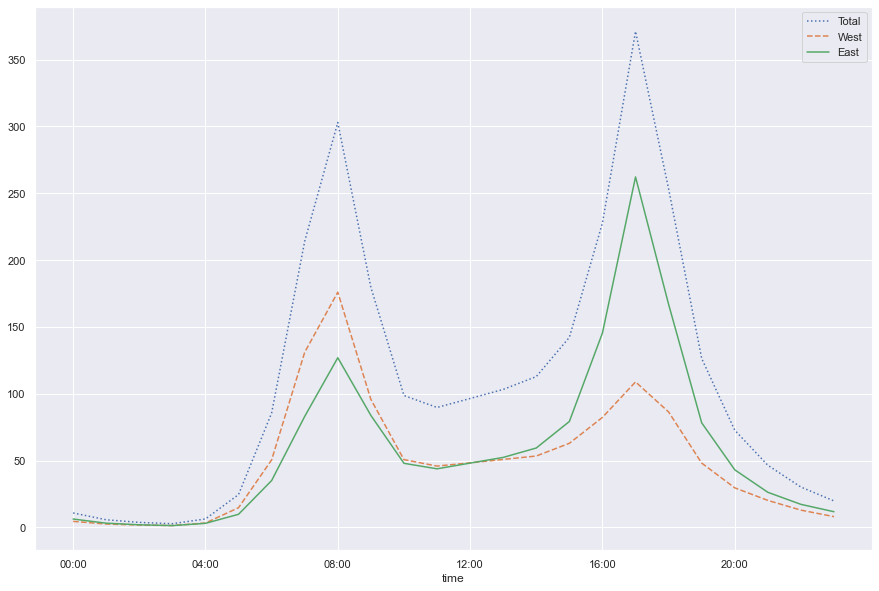

In [53]:
# averaging the hourly mean over the entire dataset
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-'], figsize=(15,10))
plt.show()

The hourly traffic is strongly bimordal distribution, with peaks around 8:00 in the morning and 5:00 in the evening. This is likely evidence of a strong component of commuter traffic crossing the bridge. This is further evidenced by the differences between western sidewalk (generally used going towards downtown Seattle), which peaks strongly in the morning, and the eastern sidewalk (generally used going away from downtown Seattle), which peaks more strongly in the evening.

We also might be curious about how things change based on the day of the week. Again, we can do this with a simple `groupby`.

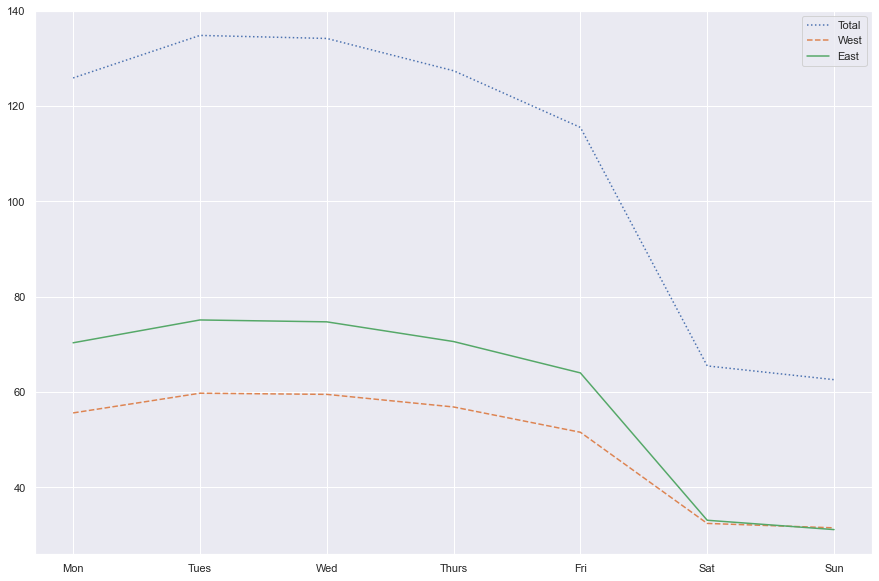

In [55]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-'], figsize=(15,10))
plt.show()

In [77]:
by_weekday

,Total,West,East
Mon,125.924323,55.602218,70.325368
Tues,134.855671,59.737841,75.117830
Wed,134.217323,59.494905,74.722418
Thurs,127.438033,56.851270,70.586763
Fri,115.544552,51.541396,64.003156
Sat,65.472207,32.404278,33.067929
Sun,62.582485,31.474457,31.108028


This shows a strong distinction between weekday and weekend totals, with around twice as many average riders crossing the bridge on Monday through Friday than on Saturday and Sunday.